# Benign Overfitting & Double Descent on an Equities Panel

Our project focuses on the study of benign overfitting in the cleanest setting where the theory is interpretable: linear regression in the overparameterized regime, with a focus on the minimum-ℓ2-norm solution and its connection to optimization. We use a real U.S. equities panel (predicting next-period returns) and build a controlled experiment where we can systematically move from underparameterized to overparameterized models while keeping the underlying prediction task fixed.

To create a bridge between theory and a realistic financial application, we start from a small set of standard equity predictors (our “real features”) and then synthetically increase the model dimension by appending irrelevant random features. This lets us vary the total number of parameters d across the interpolation threshold 𝑑 ≈ 𝑛 in a way that mirrors the theoretical setting (where extra dimensions contain no additional signal). Our main augmentation uses Gaussian noise features (the most theory-aligned choice), and we also include a random ReLU feature map extension as a robustness check using a more structured, nonlinear representation.

Throughout the notebook, we evaluate models using chronological train/validation/test splits to avoid look-ahead bias, and we report both prediction error and model complexity proxies (especially ∥w∥2 and spectral/conditioning diagnostics) to understand why performance changes as the dimension grows.

**Core questions**
1. As we increase the number of parameters 𝑑, do we observe the characteristic rise in test error near 𝑑≈𝑛 followed by recovery for 𝑑>𝑛?

2. In the interpolating regime, can we fit the training data almost perfectly while still obtaining reasonable (or improved) test performance?

3. Is generalization tied to selecting a “good” interpolating solution (e.g., minimum-norm), and can we construct “bad” interpolators with the same training fit but much worse test error?

4.  How do explicit regularization (ridge) and training-label corruption (label noise) affect the interpolating solutions and their out-of-sample behavior?


## 1. Theory background-summary- for a more detailed version see the content of the report

We study supervised regression under a linear model:
$$
y = X w^\star + \varepsilon,\qquad X\in\mathbb{R}^{n\times d},
$$
where $\mathbb{E}[\varepsilon]=0.$ Our experiments are designed to highlight what happens as we vary the **model dimension** $d$ relative to the **sample size** $n$

### Interpolation regimes and double descent
- **Underparameterized regime** ($d<n$): least squares has a unique OLS solution when $X$ has full column rank.  
- **Overparameterized regime** ($d\ge n$): there are infinitely many solutions satisfying $Xw=y$ when $X$ has full row rank.  

Empirically, test error often shows **double descent**: it increases as $d$ approaches the interpolation threshold $d\approx n$ and may decrease again for $d>n$.

### Benign overfitting and the role of the selected interpolator
When $d\ge n$, the set of interpolating solutions can be written as
$$
\{w:\; Xw=y\}=\Big\{X^\top(XX^\top)^{-1}y + v:\; v\in\ker(X)\Big\}.
$$
A canonical choice is the **minimum-$\ell_2$-norm interpolator**
$$
\hat w_{\min}=\arg\min_w \{\|w\|_2:\;Xw=y\}=X^\top(XX^\top)^{-1}y,
$$
which plays a central role in benign overfitting theory and is also the solution selected by gradient descent from $w_0=0$ under standard conditions.

### Why we include ridge 
We include ridge regression as the standard explicitly regularized baseline. Ridge stabilizes estimation in ill-conditioned settings and helps test whether the error peak around $d\approx n$ is driven by instability / norm inflation (rather than signal).

### What we diagnose empirically
- **Double descent:** test MSE vs. feature dimension $d$ under controlled overparameterization.  
- **Norm/conditioning:** spikes in $\|w\|_2$ and spectral/conditioning diagnostics of training matrices near $$d\approx n$$.  
- **Interpolation is not enough:** adding a nullspace component $v\in\ker(X)$ preserves training fit but can destroy test performance.  
- **Implicit regularization:** along the GD path, smaller-norm iterates (early stopping) can generalize better than the fully converged solution.

**References (for context; full details in the report)**  
- Bartlett et al. (2020)  
- Belkin et al. (2019)  
- Hastie et al. (2022)


In [1]:
# Imports
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
np.set_printoptions(precision=4, suppress=True)


In [2]:
# Configuration (run from repo root so paths resolve)

def find_project_root(start: Path | None = None) -> Path:
    """Walk up directories until we find a folder that contains `data/`."""
    p = (start or Path.cwd()).resolve()
    for _ in range(15):
        if (p / "data").exists():
            return p
        p = p.parent
    return Path.cwd().resolve()

PROJECT_ROOT = find_project_root()

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "equities_panel.csv"
OUT_DIR   = PROJECT_ROOT / "results" / "benign_overfitting_equities_regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Column names in the panel
DATE_COL   = "Date"
TICKER_COL = "Ticker"
TARGET_COL = "ret_fwd"  # next-period return (regression)

# Base features
BASE_FEATURES = ["ret", "log_volume", "mkt_ew_ret","mom_1m", "mom_3m", "mom_6m", "mom_12m","vol_1m", "vol_6m", "vol_12m"]
d0 = len(BASE_FEATURES)

# Chronological split (no look-ahead)
TRAIN_END = pd.Timestamp("2015-01-01")
VAL_END   = pd.Timestamp("2017-01-01")

#subset sizes
N_TRAIN = 2000
N_VAL   = 2000
N_TEST  = 2000

# Dimension sweep (we sweep d from d0 up to MAX_MULT_N*n)
MAX_MULT_N = 3

# Repetitions for uncertainty bands
SEED0   = 123
N_SEEDS = 5

# Ridge selection grid
LAMBDA_GRID = [0.0, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1.0]

# GD settings (Step: implicit regularization / early stopping)
GD_LR = 0.05
GD_ITERS_EARLYSTOP = 2000
GD_LOG_EVERY = 10

# Bad-interpolator strength
ALPHA_BAD = 200.0

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("OUT_DIR:", OUT_DIR)


PROJECT_ROOT: C:\Users\monci\OneDrive\Desktop\M2_COURSES\ADVANCED ML\Advanced-ML-benign-overfitting-finance
DATA_PATH: C:\Users\monci\OneDrive\Desktop\M2_COURSES\ADVANCED ML\Advanced-ML-benign-overfitting-finance\data\processed\equities_panel.csv
OUT_DIR: C:\Users\monci\OneDrive\Desktop\M2_COURSES\ADVANCED ML\Advanced-ML-benign-overfitting-finance\results\benign_overfitting_equities_regression


In [3]:
# Helpers 

def mse(yhat: np.ndarray, y: np.ndarray):
    return float(np.mean((yhat - y) ** 2))

def fit_standardizer(Xtr_raw: np.ndarray, eps: float = 1e-12):
    mu = Xtr_raw.mean(axis=0, keepdims=True)
    sd = Xtr_raw.std(axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return mu, sd

def apply_standardizer(X: np.ndarray, mu: np.ndarray, sd: np.ndarray) -> np.ndarray:
    return (X - mu) / sd

def zscore_cols(Z: np.ndarray, eps: float = 1e-12):
    return (Z - Z.mean(axis=0, keepdims=True)) / (Z.std(axis=0, keepdims=True) + eps)

def make_d_list(d0: int, n: int, max_mult: int):
    d1 = np.linspace(d0, max(d0, int(0.8*n)), 12)
    d2 = np.linspace(int(0.8*n), int(1.2*n), 30)
    d3 = np.linspace(int(1.2*n), int(2.0*n), 12)
    d4 = np.geomspace(2.0*n, max_mult*n, 10)
    d = np.unique(np.round(np.concatenate([d1, d2, d3, d4])).astype(int))
    d = d[d >= d0]
    return d.tolist()

# Linear solvers
def min_norm_solution(X: np.ndarray, y: np.ndarray, jitter: float = 1e-10):
    n = X.shape[0]
    K = X @ X.T
    alpha = np.linalg.solve(K + jitter*np.eye(n), y)
    return X.T @ alpha

def ridge_solution(X: np.ndarray, y: np.ndarray, lam: float, jitter: float = 1e-10):
    """Uses primal if d<=n and dual if d>n (stable near d≈n via jitter)."""
    n, d = X.shape
    if d <= n:
        A = X.T @ X + (lam + jitter) * np.eye(d)
        b = X.T @ y
        return np.linalg.solve(A, b)
    K = X @ X.T
    alpha = np.linalg.solve(K + (lam + jitter) * np.eye(n), y)
    return X.T @ alpha

@dataclass
class Split3:
    Xtr: np.ndarray; ytr: np.ndarray; dtr: np.ndarray
    Xva: np.ndarray; yva: np.ndarray; dva: np.ndarray
    Xte: np.ndarray; yte: np.ndarray; dte: np.ndarray

def subsample_split(Xtr, ytr, dtr, Xva, yva, dva, Xte, yte, dte, n_train: int, n_val: int, n_test: int, seed: int):
    """Random subsampling to control n"""
    rng = np.random.default_rng(seed)
    tr_idx = rng.choice(len(ytr), size=min(n_train, len(ytr)), replace=False)
    va_idx = rng.choice(len(yva), size=min(n_val, len(yva)), replace=False)
    te_idx = rng.choice(len(yte), size=min(n_test, len(yte)), replace=False)
    return Split3(
        Xtr=Xtr[tr_idx], ytr=ytr[tr_idx], dtr=dtr[tr_idx],
        Xva=Xva[va_idx], yva=yva[va_idx], dva=dva[va_idx],
        Xte=Xte[te_idx], yte=yte[te_idx], dte=dte[te_idx],
    )


In [4]:
# Load dataset + chronological split + standardization (train-only)

def load_dataset(path: Path):
    df = pd.read_csv(path)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values([DATE_COL, TICKER_COL]).reset_index(drop=True)

    need = [DATE_COL, TICKER_COL, TARGET_COL] + BASE_FEATURES
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df = df.dropna(subset=BASE_FEATURES + [TARGET_COL]).reset_index(drop=True)
    return df

def make_time_splits(df: pd.DataFrame, train_end: pd.Timestamp, val_end: pd.Timestamp):
    tr = df[df[DATE_COL] <= train_end].copy()
    va = df[(df[DATE_COL] > train_end) & (df[DATE_COL] <= val_end)].copy()
    te = df[df[DATE_COL] > val_end].copy()
    if len(tr) == 0 or len(va) == 0 or len(te) == 0:
        raise ValueError("One split is empty")
    return tr, va, te

df = load_dataset(DATA_PATH)
tr_df, va_df, te_df = make_time_splits(df, TRAIN_END, VAL_END)

def to_arrays(df_part: pd.DataFrame):
    X = df_part[BASE_FEATURES].to_numpy(dtype=np.float64)
    y = df_part[TARGET_COL].to_numpy(dtype=np.float64)
    d = df_part[DATE_COL].to_numpy()
    return X, y, d

Xtr_raw, ytr_raw, dtr0 = to_arrays(tr_df)
Xva_raw, yva_raw, dva0 = to_arrays(va_df)
Xte_raw, yte_raw, dte0 = to_arrays(te_df)

# Standardize features using TRAIN statistics
muX, sdX = fit_standardizer(Xtr_raw)
Xtr0 = apply_standardizer(Xtr_raw, muX, sdX)
Xva0 = apply_standardizer(Xva_raw, muX, sdX)
Xte0 = apply_standardizer(Xte_raw, muX, sdX)

# Center y using train mean 
y_mu = float(np.mean(ytr_raw))
ytr0 = ytr_raw - y_mu
yva0 = yva_raw - y_mu
yte0 = yte_raw - y_mu

print("Date range:", df[DATE_COL].min().date(), "->", df[DATE_COL].max().date())
print("Rows:", "train", len(tr_df), "val", len(va_df), "test", len(te_df))
print("Shapes:", Xtr0.shape, Xva0.shape, Xte0.shape, "| y(train) std:", float(np.std(ytr0)))

# Controlled sample size
split0 = subsample_split(Xtr0, ytr0, dtr0, Xva0, yva0, dva0, Xte0, yte0, dte0,
                         N_TRAIN, N_VAL, N_TEST, seed=SEED0)
n_eff = split0.Xtr.shape[0]
d_list = make_d_list(d0=d0, n=n_eff, max_mult=MAX_MULT_N)
print("n_eff:", n_eff, "| d0:", d0, "| d grid points:", len(d_list), "| d max:", max(d_list))


Date range: 2001-01-31 -> 2024-11-30
Rows: train 44877 val 7061 test 17100
Shapes: (44877, 10) (7061, 10) (17100, 10) | y(train) std: 0.10315807962027698
n_eff: 2000 | d0: 10 | d grid points: 61 | d max: 6000


# 2. Baselines on real features (no synthetic augmentation)

We start by establishing a realistic baseline using only the original equity predictors (feature dimension is fixed at $d=d_0$). This gives us a reference point for what can be achieved without any synthetic overparameterization.

Our main baseline model is ridge regression, which is the standard “classical” choice in noisy, low-signal settings like return prediction: it controls coefficient magnitude and improves numerical stability when features are correlated. We select the regularization strength $\lambda$ by minimizing validation MSE over a predefined grid, then report train/validation/test MSE for the best $\lambda$.

We also report two simple sanity-check baselines (predicting zero and predicting the training mean). These help confirm that the prediction task is genuinely difficult and that any improvements or degradations we observe later are meaningful.

This baseline section is important because later, when we artificially increase $d$ by adding irrelevant random features, we can compare overparameterized ridgeless/min-norm interpolators and ridge on augmented features against a model that uses only the real financial signal.

In [5]:
# Baselines on real features only

def run_baselines(split: Split3):
    rows = []
    rows.append(dict(model="predict_0",
                     train_mse=mse(np.zeros_like(split.ytr), split.ytr),
                     val_mse=mse(np.zeros_like(split.yva), split.yva),
                     test_mse=mse(np.zeros_like(split.yte), split.yte),
                     w_norm=0.0, lam=np.nan))

    mu = float(np.mean(split.ytr))
    rows.append(dict(model="predict_train_mean",
                     train_mse=mse(np.full_like(split.ytr, mu), split.ytr),
                     val_mse=mse(np.full_like(split.yva, mu), split.yva),
                     test_mse=mse(np.full_like(split.yte, mu), split.yte),
                     w_norm=0.0, lam=np.nan))
    best = None
    for lam in LAMBDA_GRID:
        w = ridge_solution(split.Xtr, split.ytr, lam)
        rec = dict(model="ridge_real_features",
                   train_mse=mse(split.Xtr @ w, split.ytr),
                   val_mse=mse(split.Xva @ w, split.yva),
                   test_mse=mse(split.Xte @ w, split.yte),
                   w_norm=float(np.linalg.norm(w)), lam=float(lam))
        if best is None or rec["val_mse"] < best["val_mse"]:
            best = rec
    rows.append(best)
    
    
    n_tr, d0 = split.Xtr.shape
    if d0 < n_tr:
        # unique least-squares solution : ridge with lam=0 in primal
        w_ls = ridge_solution(split.Xtr, split.ytr, lam=0.0) 
        model_name = "ols_real_features"
        lam_val = 0.0
    else:
        # overparameterized: minimum-norm interpolator
        w_ls = min_norm_solution(split.Xtr, split.ytr) 
        model_name = "min_norm_real_features"
        lam_val = np.nan  

    rows.append(dict(model=model_name,
                     train_mse=mse(split.Xtr @ w_ls, split.ytr),
                     val_mse=mse(split.Xva @ w_ls, split.yva),
                     test_mse=mse(split.Xte @ w_ls, split.yte),
                     w_norm=float(np.linalg.norm(w_ls)),
                     lam=lam_val))

    return pd.DataFrame(rows)

base_df = run_baselines(split0)
base_df.to_csv(OUT_DIR / "baselines.csv", index=False)
base_df


,model,train_mse,val_mse,test_mse,w_norm,lam
0,predict_0,0.011341,0.005560,0.009911,0.000000,NaN
1,predict_train_mean,0.011341,0.005565,0.009906,0.000000,NaN
2,ridge_real_features,0.011004,0.005777,0.009864,0.020167,1.0
3,ols_real_features,0.011004,0.005777,0.009864,0.020193,0.0


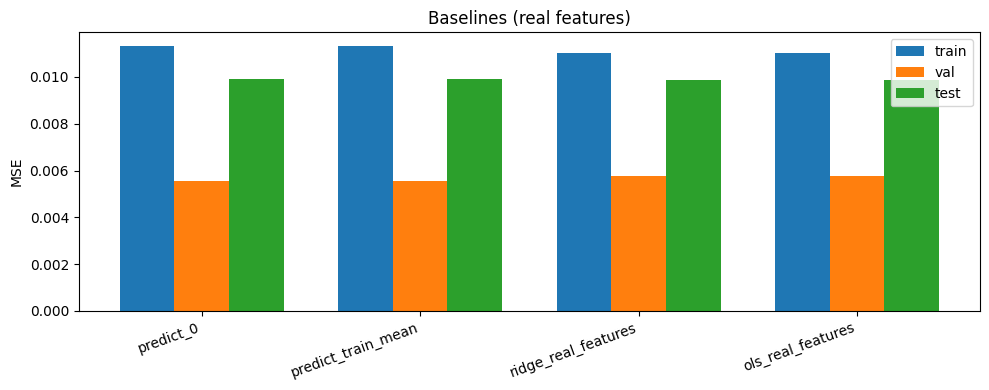

Benchmark ridge (val-selected): {'model': 'ridge_real_features', 'train_mse': 0.011004042103967614, 'val_mse': 0.0057770006529023, 'test_mse': 0.00986364166899473, 'w_norm': 0.02016675802473657, 'lam': 1.0}


In [6]:
# Visualize baseline errors
tmp = base_df.copy()
models = tmp["model"].tolist()
x = np.arange(len(models))
w = 0.25

plt.figure(figsize=(10,4))
plt.bar(x - w, tmp["train_mse"], width=w, label="train")
plt.bar(x,     tmp["val_mse"],   width=w, label="val")
plt.bar(x + w, tmp["test_mse"],  width=w, label="test")
plt.xticks(x, models, rotation=20, ha="right")
plt.ylabel("MSE")
plt.title("Baselines (real features)")
plt.legend()
plt.tight_layout()
plt.show()

ridge_row = base_df.loc[base_df["model"]=="ridge_real_features"].iloc[0]
print("Benchmark ridge (val-selected):", ridge_row.to_dict())


# 3 Double descent & benign overfitting


## 3.1 Setup and Double Descent in Test error using Gaussian features

We study overparameterized linear regression by keeping the real equity predictors fixed and
systematically increasing the parameter dimension using first, irrelevant Gaussian features. We start from the base design matrix $X_0\in\mathbb{R}^{n\times d_0}$ and generate, for each random
seed, a single “maximal” noise matrix $Z_{\max}$ For every target dimension
$d \approx d_0$ we construct a nested augmented design by taking a prefix of the noise features:
$
X(d)=\big[X_0,\; Z_{1:(d-d_0)}\big].
$

This setup is intentionally controlled: increasing $d$ adds parameters without adding signal,
so any change in out-of-sample error is driven by the geometry of overparameterization and the choice
of estimator, not by additional information.

For each $d$ we evaluate three complementary estimators:
- **Ridgeless / min-norm branch:** ordinary least squares when $d<n$, and the **minimum-$\ell_2$-norm interpolator** when $d\ge n$.
- **Ridge on the augmented design (fixed $\lambda$):** a stable comparator that applies the same regularization strength across all $d$.
- **Ridge on real features:** ridge trained only on $X_0$ with $\lambda$ selected on the validation split (our main classical baseline).

Implementation-wise, ridge is solved in closed form using the primal system when $d\le n$ and the
dual system when $d>n$, with a tiny diagonal jitter for numerical stability near $d\approx n$.
We repeat the full sweep across multiple random-feature seeds and report mean $\pm$ std bands across
seeds.


In [7]:
# Experiment 1 — Double descent via irrelevant Gaussian features

@dataclass
class GaussianAugCache:
    Ztr_max: np.ndarray
    Zva_max: np.ndarray
    Zte_max: np.ndarray

def make_gaussian_cache(split: Split3, d_max: int, seed: int):
    
    rng = np.random.default_rng(seed)
    ntr, nva, nte = split.Xtr.shape[0], split.Xva.shape[0], split.Xte.shape[0]
    extra = max(0, d_max - d0)
    if extra == 0:
        return GaussianAugCache(Ztr_max=np.zeros((ntr,0)), Zva_max=np.zeros((nva,0)), Zte_max=np.zeros((nte,0)))
    Ztr = rng.normal(size=(ntr, extra))
    Zva = rng.normal(size=(nva, extra))
    Zte = rng.normal(size=(nte, extra))
    return GaussianAugCache(Ztr_max=Ztr, Zva_max=Zva, Zte_max=Zte)

def augment_with_cache(Xbase: np.ndarray, Zmax: np.ndarray, d_total: int) -> np.ndarray:
    if d_total < Xbase.shape[1]:
        raise ValueError(f"d_total={d_total} < d0={Xbase.shape[1]}. ")
    extra = d_total - Xbase.shape[1]
    if extra == 0:
        return Xbase.copy()
    return np.concatenate([Xbase, Zmax[:, :extra]], axis=1)

def solve_ridgeless(Xtr: np.ndarray, ytr: np.ndarray):
    """
    - if d < n: unique OLS (primal) -> ridge_solution(lam=0) should compute it
    - if d >= n: choose minimum-norm interpolator -> min_norm_solution
    """
    n, d = Xtr.shape
    if d < n:
        return ridge_solution(Xtr, ytr, lam=0.0)
    else:
        return min_norm_solution(Xtr, ytr)

def choose_global_lambda(split: Split3, d_list: List[int], seed: int, lam_grid: List[float]):
    cache = make_gaussian_cache(split, d_max=max(d_list), seed=seed)

    n_eff = split.Xtr.shape[0]
    # we include d0 and n, plus a few overparam points
    candidates = [n_eff, int(2*n_eff), int(3*n_eff)]
    d_coarse = sorted({d for d in candidates if d in set(d_list)})

    if len(d_coarse) == 0:
        d_coarse = [d_list[0], d_list[len(d_list)//2], d_list[-1]]

    best_lam, best_score = None, float("inf")
    for lam in lam_grid:
        vals = []
        for d in d_coarse:
            Xtr = augment_with_cache(split.Xtr, cache.Ztr_max, d)
            Xva = augment_with_cache(split.Xva, cache.Zva_max, d)
            w = ridge_solution(Xtr, split.ytr, lam=lam)
            vals.append(mse(Xva @ w, split.yva))
        score = float(np.mean(vals))
        if score < best_score:
            best_score, best_lam = score, float(lam)
    return best_lam

def sweep_double_descent(split: Split3, d_list: List[int], seed: int, lam_fixed: float = 1e-2, lam_grid: List[float] = None):
    if lam_grid is None:
        lam_grid = list(LAMBDA_GRID)

    cache = make_gaussian_cache(split, d_max=max(d_list), seed=seed)

    # ridge(aug) with a single CV-selected lambda
    lam_star = choose_global_lambda(split, d_list, seed=seed, lam_grid=lam_grid)

    rows = []
    for d in d_list:
        Xtr = augment_with_cache(split.Xtr, cache.Ztr_max, d)
        Xva = augment_with_cache(split.Xva, cache.Zva_max, d)
        Xte = augment_with_cache(split.Xte, cache.Zte_max, d)

        # Ridgeless / min-norm 
        w_mn = solve_ridgeless(Xtr, split.ytr)
        rows.append(dict(seed=seed, d=int(d), kind="min_norm",
                         train_mse=mse(Xtr @ w_mn, split.ytr),
                         val_mse=mse(Xva @ w_mn, split.yva),
                         test_mse=mse(Xte @ w_mn, split.yte),
                         w_norm=float(np.linalg.norm(w_mn)),
                         lam=np.nan))

        # Fixed ridge comparator 
        w_rf = ridge_solution(Xtr, split.ytr, lam=lam_fixed)
        rows.append(dict(seed=seed, d=int(d), kind="ridge_fixed",
                         train_mse=mse(Xtr @ w_rf, split.ytr),
                         val_mse=mse(Xva @ w_rf, split.yva),
                         test_mse=mse(Xte @ w_rf, split.yte),
                         w_norm=float(np.linalg.norm(w_rf)),
                         lam=float(lam_fixed)))

        # ridge(aug) with CV-once lambda
        w_rcv = ridge_solution(Xtr, split.ytr, lam=lam_star)
        rows.append(dict(seed=seed, d=int(d), kind="ridge_cv",
                         train_mse=mse(Xtr @ w_rcv, split.ytr),
                         val_mse=mse(Xva @ w_rcv, split.yva),
                         test_mse=mse(Xte @ w_rcv, split.yte),
                         w_norm=float(np.linalg.norm(w_rcv)),
                         lam=float(lam_star)))

    return pd.DataFrame(rows)

def band(df: pd.DataFrame, kind: str, cols=("train_mse","val_mse","test_mse","w_norm")):
    g = df[df["kind"]==kind].groupby("d")
    out = pd.DataFrame({"d": g.size().index})
    for c in cols:
        out[c+"_mean"] = g[c].mean().values
        out[c+"_std"]  = g[c].std(ddof=0).values
    return out.sort_values("d").reset_index(drop=True)

# Run sweeps
runs = []
for k in range(N_SEEDS):
    seed = SEED0 + 100*k
    runs.append(sweep_double_descent(split0, d_list, seed=seed, lam_fixed=1e-2, lam_grid=list(LAMBDA_GRID)))

df_dd = pd.concat(runs, ignore_index=True)
df_dd.to_csv(OUT_DIR / "exp1_double_descent.csv", index=False)

b_mn  = band(df_dd, "min_norm")
b_rf  = band(df_dd, "ridge_fixed")
b_rcv = band(df_dd, "ridge_cv")

(b_mn.head(), b_rf.head(), b_rcv.head())


(     d  train_mse_mean  train_mse_std  val_mse_mean  val_mse_std  \
 0   10        0.011004       0.000000      0.005777     0.000000   
 1  155        0.010250       0.000038      0.006585     0.000084   
 2  299        0.009438       0.000079      0.007598     0.000072   
 3  444        0.008688       0.000092      0.008740     0.000303   
 4  588        0.007921       0.000082      0.009989     0.000324   
 
    test_mse_mean  test_mse_std  w_norm_mean  w_norm_std  
 0       0.009864      0.000000     0.020193    0.000000  
 1       0.010646      0.000069     0.035351    0.000891  
 2       0.011607      0.000183     0.047469    0.000704  
 3       0.012744      0.000322     0.057849    0.001741  
 4       0.014228      0.000472     0.069081    0.001171  ,
      d  train_mse_mean  train_mse_std  val_mse_mean  val_mse_std  \
 0   10        0.011004       0.000000      0.005777     0.000000   
 1  155        0.010250       0.000038      0.006585     0.000084   
 2  299        0.00943

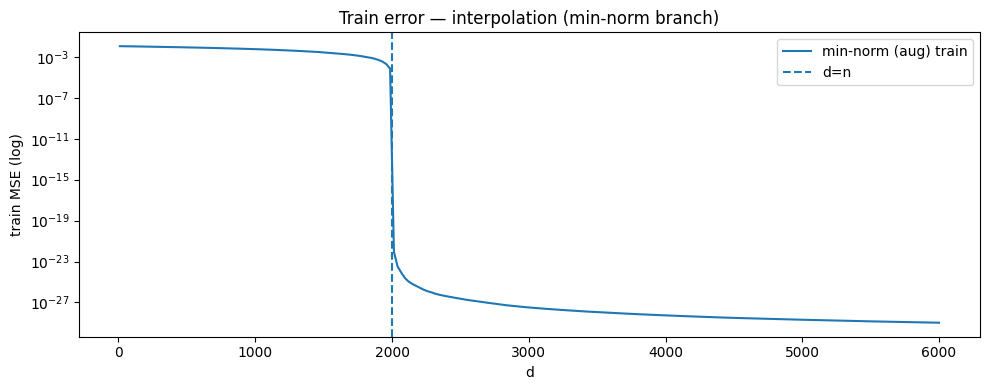

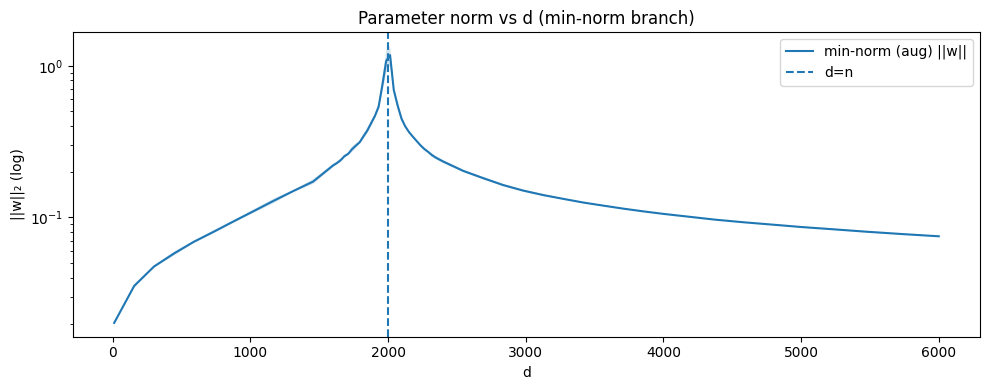

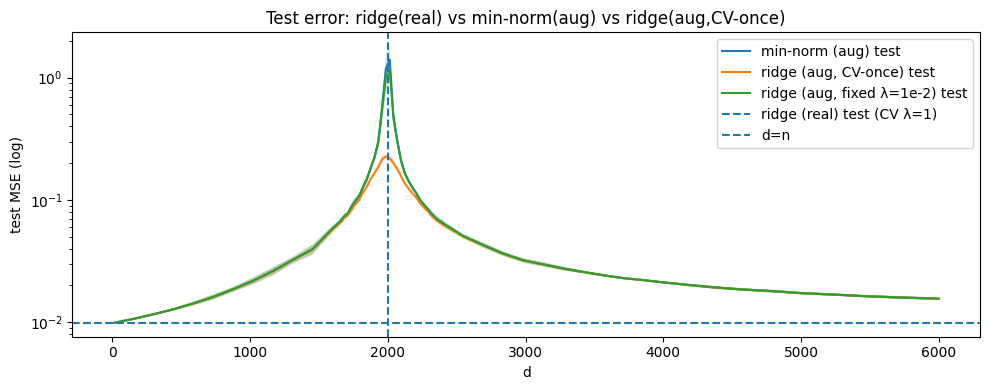

In [8]:
# Plots: compare ridge(real) vs min-norm(aug) vs ridge(aug,CV)

ridge_real_row = base_df[base_df["model"]=="ridge_real_features"].iloc[0]
ridge_real_test = float(ridge_real_row["test_mse"])
ridge_real_lam  = float(ridge_real_row["lam"])

plt.figure()
plt.plot(b_mn["d"], b_mn["train_mse_mean"], label="min-norm (aug) train")
plt.fill_between(b_mn["d"],
                 b_mn["train_mse_mean"]-b_mn["train_mse_std"],
                 b_mn["train_mse_mean"]+b_mn["train_mse_std"],
                 alpha=0.2)
plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("train MSE (log)")
plt.title("Train error — interpolation (min-norm branch)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(b_mn["d"], b_mn["w_norm_mean"], label="min-norm (aug) ||w||")
plt.fill_between(b_mn["d"],
                 b_mn["w_norm_mean"]-b_mn["w_norm_std"],
                 b_mn["w_norm_mean"]+b_mn["w_norm_std"],
                 alpha=0.2)
plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("||w||₂ (log)")
plt.title("Parameter norm vs d (min-norm branch)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()

# min-norm augmented
plt.plot(b_mn["d"], b_mn["test_mse_mean"], label="min-norm (aug) test")
plt.fill_between(b_mn["d"],
                 b_mn["test_mse_mean"]-b_mn["test_mse_std"],
                 b_mn["test_mse_mean"]+b_mn["test_mse_std"],
                 alpha=0.2)

# ridge augmented with CV-once lambda
plt.plot(b_rcv["d"], b_rcv["test_mse_mean"], label="ridge (aug, CV-once) test")
plt.fill_between(b_rcv["d"],
                 b_rcv["test_mse_mean"]-b_rcv["test_mse_std"],
                 b_rcv["test_mse_mean"]+b_rcv["test_mse_std"],
                 alpha=0.2)

# fixed ridge 
plt.plot(b_rf["d"], b_rf["test_mse_mean"], label="ridge (aug, fixed λ=1e-2) test")
plt.fill_between(b_rf["d"],
                 b_rf["test_mse_mean"]-b_rf["test_mse_std"],
                 b_rf["test_mse_mean"]+b_rf["test_mse_std"],
                 alpha=0.15)

# ridge on real features 
plt.axhline(ridge_real_test, linestyle="--",
            label=f"ridge (real) test (CV λ={ridge_real_lam:.2g})")

plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("test MSE (log)")
plt.title("Test error: ridge(real) vs min-norm(aug) vs ridge(aug,CV-once)")
plt.legend()
plt.tight_layout()
plt.show()


## 3.2 Diagnostic — Conditioning around the interpolation threshold

To better understand why test error can deteriorate near the interpolation threshold, we add a
numerical stability diagnostic based on the spectrum of the training Gram matrix.

For each model dimension $d$ in the Gaussian augmentation sweep, we form the training Gram matrix
$$
G(d) = \frac{1}{n}\,X(d)X(d)^\top,
$$
and compute two simple quantities:
- the smallest eigenvalue $\lambda_{\min}(G(d)),$
- the condition number $\kappa(G(d))=\frac{\lambda_{\max}(G(d))}{\lambda_{\min}(G(d))}$

We track these metrics as $d$ varies because the min-norm interpolator depends on inverting
$XX^\top$ (up to numerical jitter). When $G(d)$ has very small eigenvalues, the inverse problem
becomes sensitive to noise and small perturbations, which can translate into large coefficient norms
and unstable out-of-sample behavior.

In addition to summary statistics ($\lambda_{\min}$ and $\kappa$), we also visualize the full
eigenvalue spectrum of $G(d)$ for a few representative dimensions near
$d\approx n$ to see how the distribution of eigenvalues changes across regimes.


In [9]:
# Conditioning diagnostic near d≈n 

def gram_minmax_eigs(X: np.ndarray):
    G = (X @ X.T) / X.shape[0]
    ev = np.linalg.eigvalsh(G)  # sorted
    return float(ev[0]), float(ev[-1])

seed_cond = SEED0 + 999
cache = make_gaussian_cache(split0, d_max=max(d_list), seed=seed_cond)

# Focus near interpolation threshold
d_focus = sorted(set(
    list(np.linspace(d0, int(0.8*n_eff), 8, dtype=int)) +
    list(np.linspace(int(0.8*n_eff), int(1.2*n_eff), 18, dtype=int)) +
    list(np.linspace(int(1.2*n_eff), int(2.0*n_eff), 8, dtype=int))
))

rows = []
for d in d_focus:
    Xtr = augment_with_cache(split0.Xtr, cache.Ztr_max, d)
    lam_min, lam_max = gram_minmax_eigs(Xtr)
    rows.append(dict(d=int(d), lam_min=lam_min, lam_max=lam_max, cond=lam_max/max(lam_min,1e-30)))
cond_df = pd.DataFrame(rows).sort_values("d")
cond_df.to_csv(OUT_DIR / "diagnostic_conditioning.csv", index=False)
cond_df.head()


,d,lam_min,lam_max,cond
0,10,-2.296699e-15,3.484116,3.484116e+30
1,237,-1.129098e-15,3.640248,3.640248e+30
2,464,-1.529128e-15,3.818542,3.818542e+30
3,691,-1.268061e-15,3.983707,3.983707e+30
4,918,-1.414584e-15,4.186850,4.186850e+30


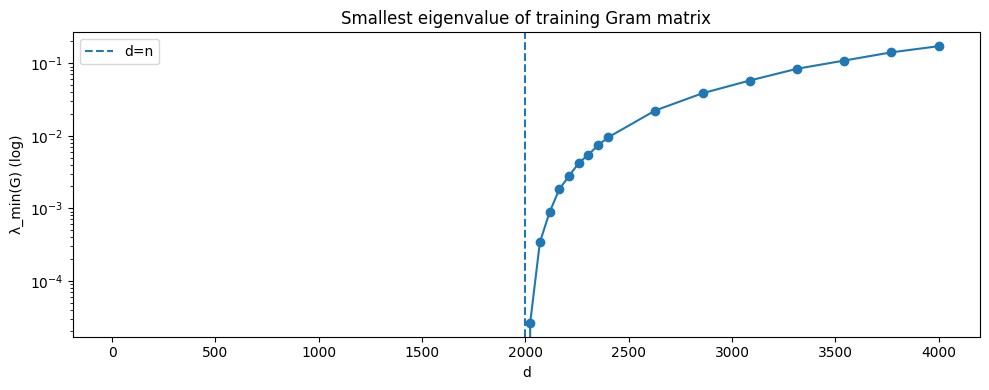

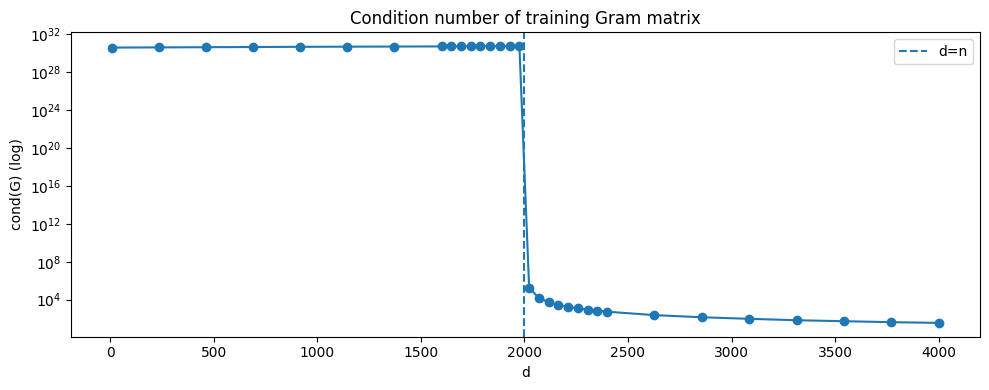

In [10]:
plt.figure()
plt.plot(cond_df["d"], cond_df["lam_min"], marker="o")
plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("λ_min(G) (log)")
plt.title("Smallest eigenvalue of training Gram matrix")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(cond_df["d"], cond_df["cond"], marker="o")
plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("cond(G) (log)")
plt.title("Condition number of training Gram matrix")
plt.legend()
plt.tight_layout()
plt.show()


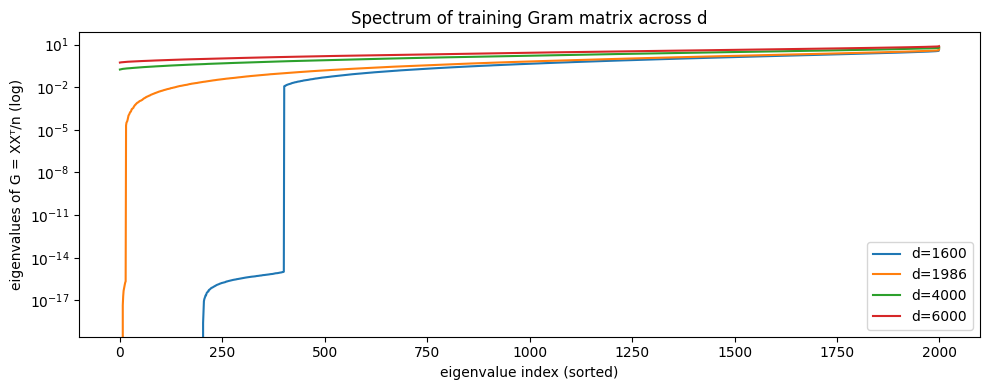

In [11]:
# Eigenvalue spectrum of Gram matrix for a few d values

def gram_eigs(X: np.ndarray):
    G = (X @ X.T) / X.shape[0]
    return np.linalg.eigvalsh(G)  

seed_spec = SEED0 + 123
cache_spec = make_gaussian_cache(split0, d_max=max(d_list), seed=seed_spec)

# pick representative d's around threshold and overparam
d_targets = [int(0.8*n_eff), int(1.0*n_eff), int(2.0*n_eff), int(3.0*n_eff)]

d_snap = []
for dt in d_targets:
    d_snap.append(min(d_list, key=lambda x: abs(x-dt)))
d_snap = sorted(set(d_snap))

plt.figure()
for d in d_snap:
    Xtr = augment_with_cache(split0.Xtr, cache_spec.Ztr_max, d)
    ev = gram_eigs(Xtr)
    plt.plot(ev, label=f"d={d}")

plt.yscale("log")
plt.xlabel("eigenvalue index (sorted)")
plt.ylabel("eigenvalues of G = XXᵀ/n (log)")
plt.title("Spectrum of training Gram matrix across d")
plt.legend()
plt.tight_layout()
plt.show()


## 3.3 Robustness of features: Random ReLU features (nonlinear random feature map)

As a robustness check beyond Gaussian noise, we also augment the base design with **random ReLU features**:
$$
Z=\mathrm{ReLU}(X_0W+b), \qquad W_{ij}\sim\mathcal{N}(0,1/d_0).
$$
For each $d\ge d_0$ we build
$
X(d)=[X_0,\;Z_{1:(d-d_0)}],
$
standardizing $Z$ using training-set statistics, and repeat the same sweep. This tests
whether our qualitative findings are specific to i.i.d. Gaussian augmentation or persist under a
simple nonlinear random-feature map.



In [12]:
# Random ReLU augmentation

@dataclass
class ReluMap:
    W: np.ndarray
    b: np.ndarray

def make_relu_map(d_in: int, m: int, seed: int):
    rng = np.random.default_rng(seed)
    W = rng.normal(size=(d_in, m)) / np.sqrt(d_in)
    b = rng.normal(size=(m,))
    return ReluMap(W=W, b=b)

def relu(x: np.ndarray):
    return np.maximum(x, 0.0)

@dataclass
class ReluAugCache:
    Ztr: np.ndarray
    Zva: np.ndarray
    Zte: np.ndarray

def make_relu_cache(split: Split3, m_max: int, seed: int):
    fmap = make_relu_map(d_in=d0, m=m_max, seed=seed)
    Ztr = relu(split.Xtr @ fmap.W + fmap.b)
    Zva = relu(split.Xva @ fmap.W + fmap.b)
    Zte = relu(split.Xte @ fmap.W + fmap.b)
    # standardize *using train stats* (avoid leakage)
    mu, sd = fit_standardizer(Ztr)
    Ztr = apply_standardizer(Ztr, mu, sd)
    Zva = apply_standardizer(Zva, mu, sd)
    Zte = apply_standardizer(Zte, mu, sd)
    return ReluAugCache(Ztr=Ztr, Zva=Zva, Zte=Zte)

def augment_relu(split: Split3, cache: ReluAugCache, d_total: int):
    if d_total <= d0:
        return split.Xtr[:, :d_total].copy(), split.Xva[:, :d_total].copy(), split.Xte[:, :d_total].copy()
    extra = d_total - d0
    Xtr = np.concatenate([split.Xtr, cache.Ztr[:, :extra]], axis=1)
    Xva = np.concatenate([split.Xva, cache.Zva[:, :extra]], axis=1)
    Xte = np.concatenate([split.Xte, cache.Zte[:, :extra]], axis=1)
    return Xtr, Xva, Xte

def sweep_relu(split: Split3, d_list: List[int], seed: int):
    m_max = max(d_list) - d0
    cache = make_relu_cache(split, m_max=m_max, seed=seed)
    rows = []
    for d in d_list:
        Xtr, Xva, Xte = augment_relu(split, cache, d_total=int(d))
        w_mn = ridge_solution(Xtr, split.ytr, lam=0.0)
        rows.append(dict(seed=seed, d=int(d), kind="relu_min_norm",
                         train_mse=mse(Xtr @ w_mn, split.ytr),
                         val_mse=mse(Xva @ w_mn, split.yva),
                         test_mse=mse(Xte @ w_mn, split.yte),
                         w_norm=float(np.linalg.norm(w_mn))))
    return pd.DataFrame(rows)

runs = []
for k in range(N_SEEDS):
    seed = SEED0 + 2000 + 100*k
    runs.append(sweep_relu(split0, d_list, seed=seed))
df_relu = pd.concat(runs, ignore_index=True)
df_relu.to_csv(OUT_DIR / "extension_relu.csv", index=False)

df_relu = df_relu.copy(); df_relu["kind"]="min_norm"
b_relu = band(df_relu, "min_norm")


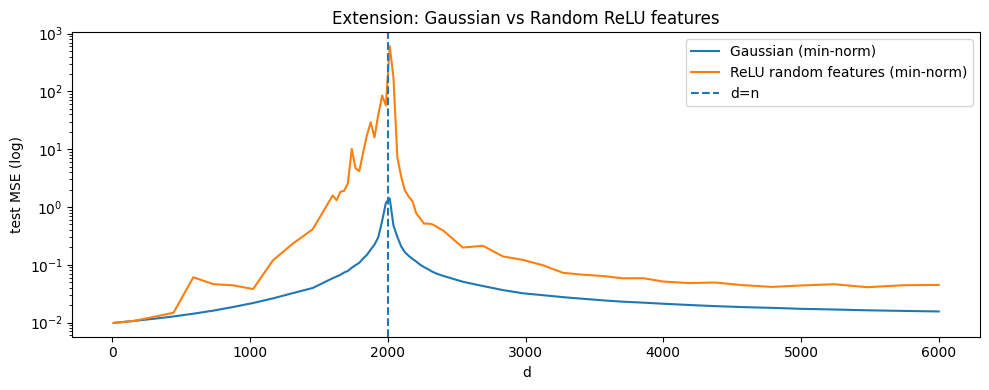

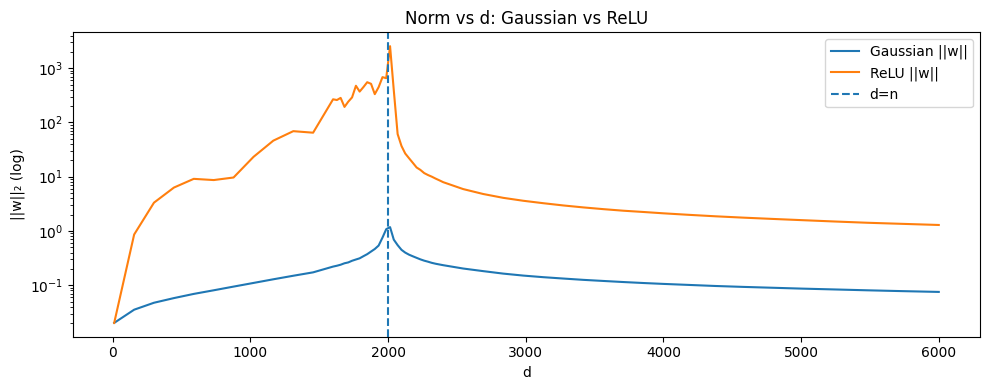

In [13]:
# Compare Gaussian vs ReLU (min-norm)

plt.figure()
plt.plot(b_mn["d"], b_mn["test_mse_mean"], label="Gaussian (min-norm)")
plt.plot(b_relu["d"], b_relu["test_mse_mean"], label="ReLU random features (min-norm)")
plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("test MSE (log)")
plt.title("Extension: Gaussian vs Random ReLU features")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(b_mn["d"], b_mn["w_norm_mean"], label="Gaussian ||w||")
plt.plot(b_relu["d"], b_relu["w_norm_mean"], label="ReLU ||w||")
plt.axvline(n_eff, linestyle="--", label="d=n")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("||w||₂ (log)")
plt.title("Norm vs d: Gaussian vs ReLU")
plt.legend()
plt.tight_layout()
plt.show()


## 3.4 Control — Not all interpolators generalize

In the overparameterized regime, interpolation ($Xw=y$) does not uniquely determine the model.
Starting from the minimum-$\ell_2$-norm interpolator $w_{\mathrm{mn}}$, we build alternative
interpolators by adding a nullspace direction:
$$
w_{\text{bad}} = w_{\mathrm{mn}} + \alpha v,\qquad Xv=0.
$$
Because $Xv=0$, training predictions are unchanged, but a large $\alpha$ inflates $\|w\|_2$ and
can strongly degrade test performance. This directly illustrates the decomposition
$$
w = \hat w_{\mathrm{mn}} + v,\quad v\in\ker(X),
$$
and shows why which interpolator is selected matters for generalization.



In [14]:
# Control: construct a high-norm interpolating solution in the overparameterized regime

def project_to_nullspace(X: np.ndarray, r: np.ndarray, jitter: float = 1e-10):
    """Return v = (I - X^T (X X^T)^-1 X) r"""
    n = X.shape[0]
    K = X @ X.T
    alpha = np.linalg.solve(K + jitter*np.eye(n), X @ r)  # solves (XX^T) alpha = X r
    return r - X.T @ alpha

d_over = int(2 * n_eff)
seed_ctrl = SEED0 + 4242
cache = make_gaussian_cache(split0, d_max=d_over, seed=seed_ctrl)
Xtr = augment_with_cache(split0.Xtr, cache.Ztr_max, d_over)
Xte = augment_with_cache(split0.Xte, cache.Zte_max, d_over)

# Good interpolator
w_mn = min_norm_solution(Xtr, split0.ytr)

# Nullspace direction
rng = np.random.default_rng(seed_ctrl + 1)
r = rng.normal(size=Xtr.shape[1])
v = project_to_nullspace(Xtr, r)
v = v / (np.linalg.norm(v) + 1e-12)

w_bad = w_mn + ALPHA_BAD * v

res_mn  = mse(Xtr @ w_mn,  split0.ytr)
res_bad = mse(Xtr @ w_bad, split0.ytr)

step5 = pd.DataFrame([
    dict(model="min_norm", train_mse=res_mn,  test_mse=mse(Xte @ w_mn,  split0.yte),  w_norm=float(np.linalg.norm(w_mn))),
    dict(model=f"bad_interpolator (alpha={ALPHA_BAD:g})", train_mse=res_bad, test_mse=mse(Xte @ w_bad, split0.yte), w_norm=float(np.linalg.norm(w_bad))),
])
step5.to_csv(OUT_DIR / "control_bad_interpolator.csv", index=False)
step5


,model,train_mse,test_mse,w_norm
0,min_norm,6.183052e-29,0.021312,0.109211
1,bad_interpolator (alpha=200),1.086624e-22,38900.566702,200.000030


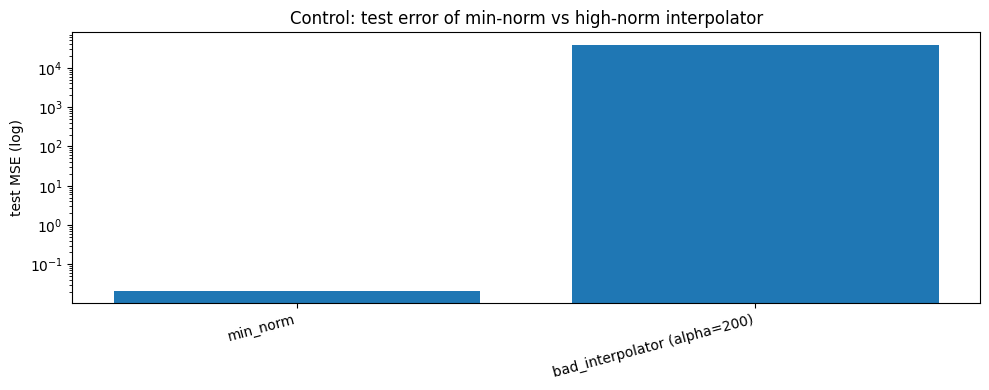

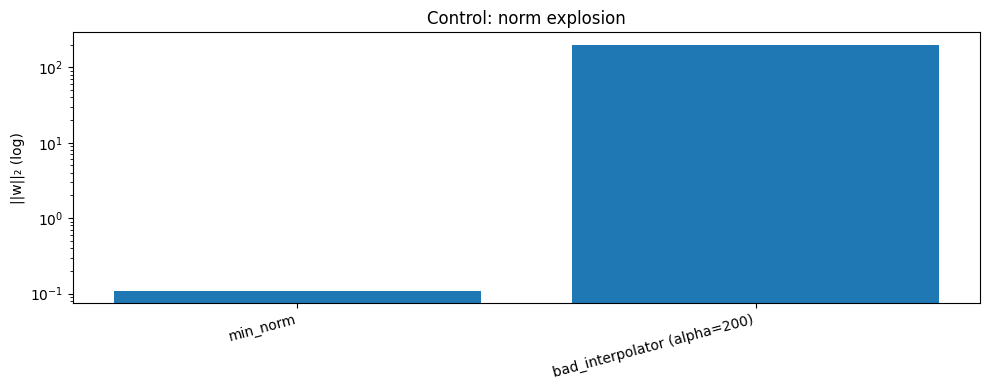

In [15]:
plt.figure()
plt.bar(step5["model"], step5["test_mse"])
plt.yscale("log")
plt.ylabel("test MSE (log)")
plt.title("Control: test error of min-norm vs high-norm interpolator")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(step5["model"], step5["w_norm"])
plt.yscale("log")
plt.ylabel("||w||₂ (log)")
plt.title("Control: norm explosion")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()


# 4. Implicit Regularization via Optimization

## 4.1 Early stopping with gradient descent
We run gradient descent on the squared loss starting from $w_0=0$ on a fixed overparameterized design (we use a large $d$ such as $d=3n$).
Along the GD path, training error decreases while the parameter norm $\|w_t\|_2$ grows.

We compare the model selected by early stopping (the iteration $t^\star$ minimizing validation MSE) to the fully converged solution. This illustrates implicit regularization: stopping early selects a smaller-norm solution that can generalize better.

We also verify numerically that GD from $w_0=0\in(\ker X)^\perp$ converges to the minimum-$\ell_2$-norm interpolator
$$
\hat w_{\min}=X^\top(XX^\top)^{-1}y,
$$
by comparing a late GD iterate to the closed-form solution.


In [16]:
def spectral_norm_power_iteration(A: np.ndarray, n_iter: int = 60, seed: int = 0):
    """
    Approximates ||A||_2 (largest singular value) using power iteration on A^T A.
    Returns an estimate of sigma_max(A).
    """
    rng = np.random.default_rng(seed)
    v = rng.normal(size=(A.shape[1],))
    v /= (np.linalg.norm(v) + 1e-12)
    for _ in range(n_iter):
        v = A.T @ (A @ v)
        v /= (np.linalg.norm(v) + 1e-12)
    Av = A @ v
    return float(np.linalg.norm(Av))   # ~ sigma_max(A)


def gd_with_logs(Xtr, ytr, Xva, yva, Xte, yte, lr: float, iters: int, log_every: int = 10):

    n, d = Xtr.shape
    w = np.zeros(d)
    logs = []

    logs.append(dict(iter=0,
                 train_mse=mse(Xtr @ w, ytr),
                 val_mse=mse(Xva @ w, yva),
                 test_mse=mse(Xte @ w, yte),
                 w_norm=float(np.linalg.norm(w))))

    for t in range(1, iters + 1):
    # update w
        r = Xtr @ w - ytr
        grad = (2.0 / n) * (Xtr.T @ r)   # gradient of (1/n)||Xw-y||^2
        w -= lr * grad

        if t % log_every == 0:
            logs.append(dict(
                iter=t,
                train_mse=mse(Xtr @ w, ytr),
                val_mse=mse(Xva @ w, yva),
                test_mse=mse(Xte @ w, yte),
                w_norm=float(np.linalg.norm(w)),
            ))

    return w, pd.DataFrame(logs)



In [24]:
# Early stopping (GD) at fixed d = 3n

n_eff = split0.Xtr.shape[0]
d_es  = int(3 * n_eff)

seed_es = SEED0 + 777
cache_es = make_gaussian_cache(split0, d_max=d_es, seed=seed_es)

Xtr_es = augment_with_cache(split0.Xtr, cache_es.Ztr_max, d_es)
Xva_es = augment_with_cache(split0.Xva, cache_es.Zva_max, d_es)
Xte_es = augment_with_cache(split0.Xte, cache_es.Zte_max, d_es)

ytr, yva, yte = split0.ytr, split0.yva, split0.yte

# Safe-ish GD step size from spectral norm bound: eta < 1/L, L=(||X||_2^2)/n
sigma_max = spectral_norm_power_iteration(Xtr_es, n_iter=60, seed=seed_es)
L = (sigma_max**2) / Xtr_es.shape[0]
eta_max = 1.0 / L

gd_iters = 4000
log_every = 10
gd_lr = min(1e-2, 0.9 * eta_max)

print(f"[GD] d={d_es} (≈3n), lr={gd_lr:.3g}, eta_max≈{eta_max:.3g}, iters={gd_iters}, log_every={log_every}")

# Run GD and pick early-stopping iteration by validation MSE
w_final, logdf = gd_with_logs(
    Xtr_es, ytr, Xva_es, yva, Xte_es, yte,
    lr=gd_lr, iters=gd_iters, log_every=log_every
)

# Avoid the 'best_iter=0' case by searching over iter>0
best_idx  = logdf.loc[logdf["iter"] > 0, "val_mse"].idxmin()
best_iter = int(logdf.loc[best_idx, "iter"])
best_row  = logdf.loc[logdf["iter"] == best_iter].iloc[0]

print("best_iter:", best_iter,
      "| val:", float(best_row["val_mse"]),
      "| test:", float(best_row["test_mse"]))

# Re-run up to best_iter to recover the actual early-stopped weights
w_best, _ = gd_with_logs(
    Xtr_es, ytr, Xva_es, yva, Xte_es, yte,
    lr=gd_lr, iters=best_iter, log_every=best_iter
)

# Compare to closed-form min-norm interpolator
w_mn = min_norm_solution(Xtr_es, ytr)
rel_dist = float(np.linalg.norm(w_final - w_mn) / (np.linalg.norm(w_mn) + 1e-12))
print(f"rel ||w_gd - w_mn|| / ||w_mn|| = {rel_dist:.2e}")

print("min-norm:",
      "train", mse(Xtr_es @ w_mn, ytr),
      "| val", mse(Xva_es @ w_mn, yva),
      "| test", mse(Xte_es @ w_mn, yte),
      "| ||w||", float(np.linalg.norm(w_mn)))

print("GD final:",
      "train", mse(Xtr_es @ w_final, ytr),
      "| val", mse(Xva_es @ w_final, yva),
      "| test", mse(Xte_es @ w_final, yte),
      "| ||w||", float(np.linalg.norm(w_final)))

print("GD best:",
      "train", mse(Xtr_es @ w_best, ytr),
      "| val", mse(Xva_es @ w_best, yva),
      "| test", mse(Xte_es @ w_best, yte),
      "| ||w||", float(np.linalg.norm(w_best)))

logdf.to_csv(OUT_DIR / "early_stopping_path.csv", index=False)
logdf.head()


[GD] d=6000 (≈3n), lr=0.01, eta_max≈0.132, iters=4000, log_every=10
best_iter: 10 | val: 0.006179736559313945 | test: 0.010488948180082997
rel ||w_gd - w_mn|| / ||w_mn|| = 4.35e-14
min-norm: train 1.0323261672951078e-29 | val 0.010774712746014152 | test 0.015083360259447648 | ||w|| 0.0744588813173037
GD final: train 5.1034290366373435e-33 | val 0.010774712746014553 | test 0.015083360259448035 | ||w|| 0.07445888131730645
GD best: train 0.00398212219293267 | val 0.006179736559313945 | test 0.010488948180082997 | ||w|| 0.02688718234054792


,iter,train_mse,val_mse,test_mse,w_norm
0,0,0.011341,0.005560,0.009911,0.000000
1,10,0.003982,0.006180,0.010489,0.026887
2,20,0.001919,0.007055,0.011359,0.040702
3,30,0.001081,0.007762,0.012078,0.049055
4,40,0.000663,0.008309,0.012642,0.054657


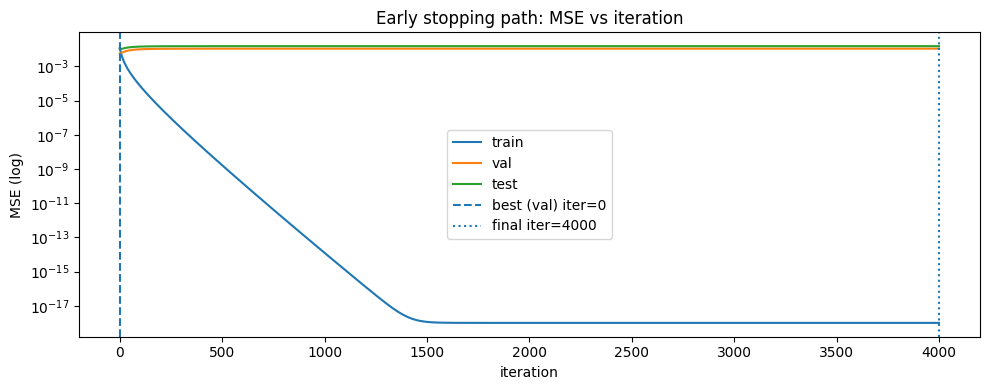

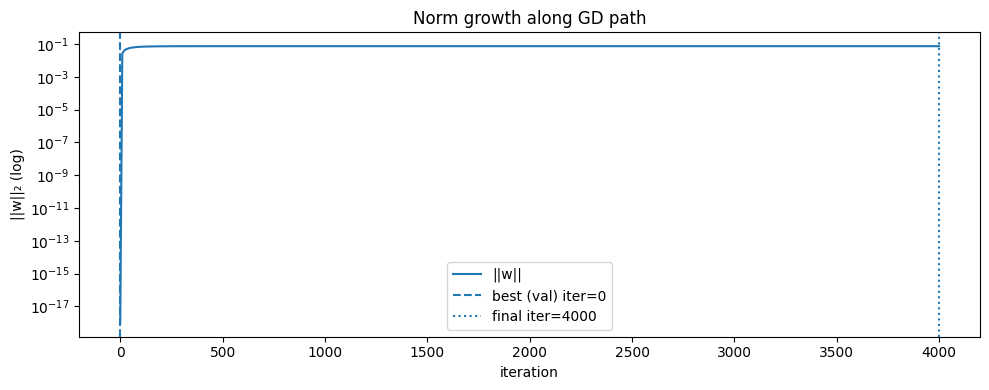

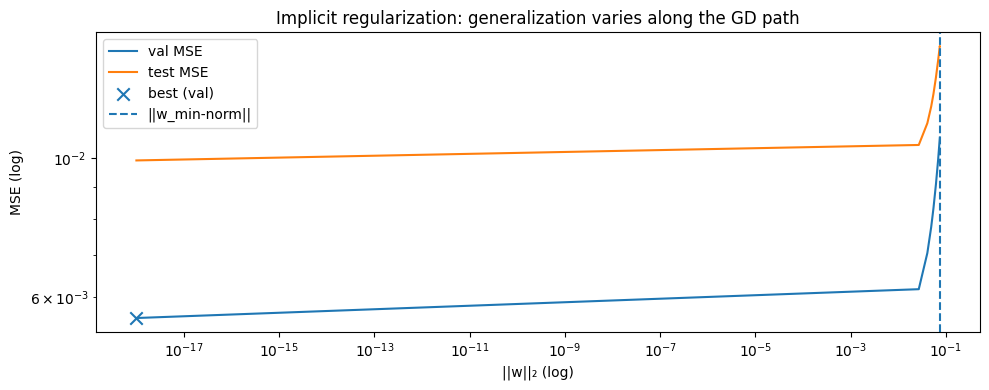

In [25]:
# Recompute best_iter / best_row inside the plotting cell 
best_iter = int(logdf.loc[logdf["val_mse"].idxmin(), "iter"])
best_row  = logdf.loc[logdf["iter"] == best_iter].iloc[0]
last_iter = int(logdf["iter"].iloc[-1])

eps = 1e-18

# 1) Early stopping path: MSE vs iteration
plt.figure()
plt.plot(logdf["iter"], logdf["train_mse"] + eps, label="train")
plt.plot(logdf["iter"], logdf["val_mse"] + eps,   label="val")
plt.plot(logdf["iter"], logdf["test_mse"] + eps,  label="test")
plt.axvline(best_iter, linestyle="--", label=f"best (val) iter={best_iter}")
plt.axvline(last_iter, linestyle=":",  label=f"final iter={last_iter}")
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("MSE (log)")
plt.title("Early stopping path: MSE vs iteration")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Norm growth along GD path
plt.figure()
plt.plot(logdf["iter"], logdf["w_norm"] + eps, label="||w||")
plt.axvline(best_iter, linestyle="--", label=f"best (val) iter={best_iter}")
plt.axvline(last_iter, linestyle=":",  label=f"final iter={last_iter}")
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("||w||₂ (log)")
plt.title("Norm growth along GD path")
plt.legend()
plt.tight_layout()
plt.show()

# 3) MSE as a function of norm 
# Display the same GD trajectory, but with ||w|| on the x-axis.
dfp = logdf.copy()  # keep iteration order 
plt.figure()
plt.plot(dfp["w_norm"] + eps, dfp["val_mse"] + eps,  label="val MSE")
plt.plot(dfp["w_norm"] + eps, dfp["test_mse"] + eps, label="test MSE")
plt.scatter([best_row.loc["w_norm"] + eps], [best_row.loc["val_mse"] + eps],
            marker="x", s=80, label="best (val)")

try:
    plt.axvline(np.linalg.norm(w_mn) + eps, linestyle="--", label="||w_min-norm||")
except NameError:
    pass

plt.xscale("log"); plt.yscale("log")
plt.xlabel("||w||₂ (log)")
plt.ylabel("MSE (log)")
plt.title("Implicit regularization: generalization varies along the GD path")
plt.legend()
plt.tight_layout()
plt.show()


# 5. Effect of Label Noise on Interpolating Solutions

## 5.1 Robustness 

Benign overfitting can be sensitive to noise conditions. We stress-test this by corrupting only the
training labels with Gaussian noise:
$$
y^{(\sigma)} = y + \sigma \cdot \mathrm{std}(y)\cdot \eta,\qquad \eta\sim\mathcal{N}(0,1),
$$
fit the min-norm interpolator at a fixed overparameterized dimension ($d=3n$),
and evaluate on the clean validation/test labels. Since $\hat w_{\min}$ depends linearly on $y$
through $(XX^\top)^{-1}y $, increasing $\sigma$ directly probes how label corruption is amplified
into larger norms and worse out-of-sample error.


In [19]:
# Label-noise experiment

SIGMAS = [0.0, 0.1, 0.25, 0.5, 1.0]
N_NOISE_SEEDS = 10
d_noise = int(3*n_eff)

rows = []
y_std = float(np.std(split0.ytr))

for k in range(N_NOISE_SEEDS):
    seed = SEED0 + 9000 + k
    rng = np.random.default_rng(seed)

    # fixed augmentation cache per seed
    cache = make_gaussian_cache(split0, d_max=d_noise, seed=seed)
    Xtr = augment_with_cache(split0.Xtr, cache.Ztr_max, d_noise)
    Xte = augment_with_cache(split0.Xte, cache.Zte_max, d_noise)

    for sigma in SIGMAS:
        eps = rng.normal(size=split0.ytr.shape)
        y_noisy = split0.ytr + float(sigma) * y_std * eps
        w = min_norm_solution(Xtr, y_noisy)
        rows.append(dict(seed=seed, sigma=float(sigma),
                         train_mse_noisy=mse(Xtr@w, y_noisy),
                         test_mse_clean=mse(Xte@w, split0.yte),
                         w_norm=float(np.linalg.norm(w))))

noise_df = pd.DataFrame(rows)
noise_df.to_csv(OUT_DIR / "robustness_label_noise.csv", index=False)

agg = noise_df.groupby("sigma").agg(
    test_mean=("test_mse_clean","mean"),
    test_std=("test_mse_clean","std"),
    w_mean=("w_norm","mean"),
    w_std=("w_norm","std"),
).reset_index()
agg


,sigma,test_mean,test_std,w_mean,w_std
0,0.00,0.015457,0.000499,0.074925,0.000652
1,0.10,0.015523,0.000480,0.075383,0.000643
2,0.25,0.015833,0.000500,0.077131,0.000637
3,0.50,0.016869,0.000735,0.084148,0.001078
4,1.00,0.020975,0.000962,0.105696,0.002565


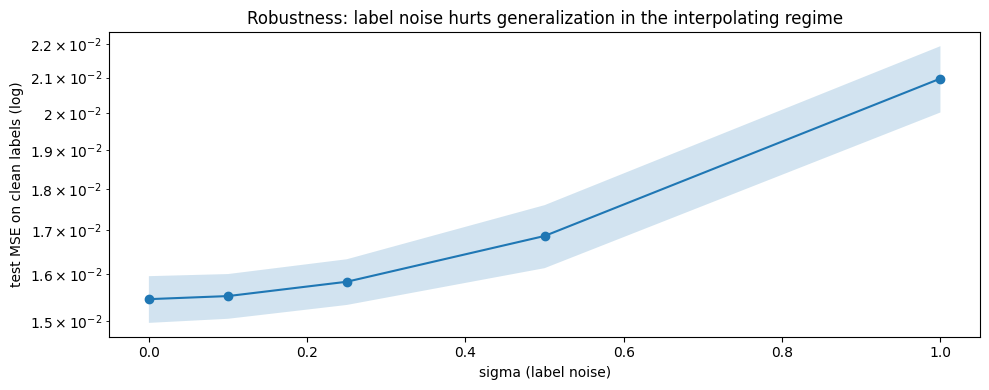

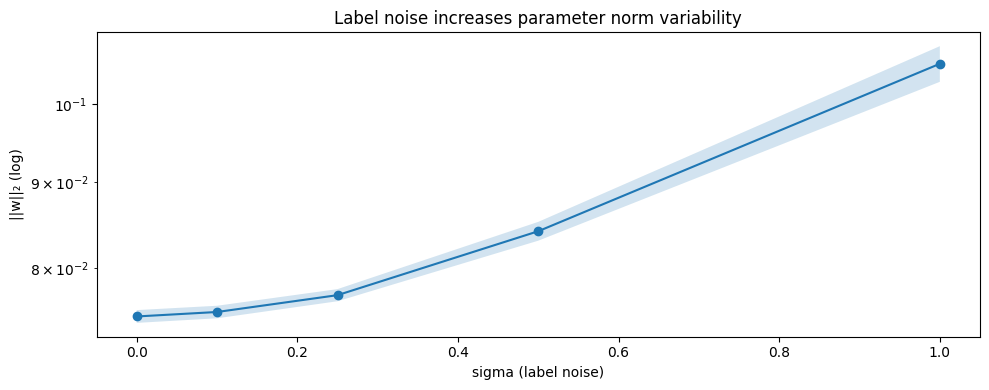

In [20]:
plt.figure()
plt.plot(agg["sigma"], agg["test_mean"], marker="o")
plt.fill_between(agg["sigma"], agg["test_mean"]-agg["test_std"], agg["test_mean"]+agg["test_std"], alpha=0.2)
plt.yscale("log")
plt.xlabel("sigma (label noise)")
plt.ylabel("test MSE on clean labels (log)")
plt.title("Robustness: label noise hurts generalization in the interpolating regime")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(agg["sigma"], agg["w_mean"], marker="o")
plt.fill_between(agg["sigma"], agg["w_mean"]-agg["w_std"], agg["w_mean"]+agg["w_std"], alpha=0.2)
plt.yscale("log")
plt.xlabel("sigma (label noise)")
plt.ylabel("||w||₂ (log)")
plt.title("Label noise increases parameter norm variability")
plt.tight_layout()
plt.show()


## Reproducibility Block

In [23]:

import sys, platform, subprocess

print("Python:", sys.version.replace("\n"," "))
print("Platform:", platform.platform())

print("\nPaths / config")
print("DATA_PATH:", DATA_PATH)
print("OUT_DIR:", OUT_DIR)
print("N_SEEDS:", N_SEEDS, "| SEED0:", SEED0)

try:
    import numpy as np, pandas as pd, matplotlib
    print("\nVersions")
    print("numpy:", np.__version__)
    print("pandas:", pd.__version__)
    print("matplotlib:", matplotlib.__version__)
except Exception as e:
    print("Version check failed:", e)

try:
    print("\nGit commit:", subprocess.check_output(["git","rev-parse","HEAD"]).decode().strip())
except Exception as e:
    print("\nGit commit unavailable:", e)


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0

Paths / config
DATA_PATH: C:\Users\monci\OneDrive\Desktop\M2_COURSES\ADVANCED ML\Advanced-ML-benign-overfitting-finance\data\processed\equities_panel.csv
OUT_DIR: C:\Users\monci\OneDrive\Desktop\M2_COURSES\ADVANCED ML\Advanced-ML-benign-overfitting-finance\results\benign_overfitting_equities_regression
N_SEEDS: 5 | SEED0: 123

Versions
numpy: 2.1.3
pandas: 2.2.3
matplotlib: 3.9.2

Git commit: 968b8f7caa313cedb5758103641d826437779923
